## 1. Carga de librerias, modelos y herramientas

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utilsforecast.preprocessing import fill_gaps
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

In [49]:
def pretreat_data_df(df, col_name):
    new_df = df[df['interaction'] == col_name].copy()
    new_df.rename(columns={'data.value': col_name}, inplace=True)
    new_df.drop(columns='interaction', inplace=True)
    new_df.set_index('timestamp', inplace=True)
    new_df[col_name] = new_df[col_name].astype(float)
    return new_df

def pretreat_true_false_data_df(df, col_name):
    new_df = df[df['interaction'] == col_name].copy()
    new_df.rename(columns={'data.value': col_name}, inplace=True)
    new_df.drop(columns='interaction', inplace=True)
    new_df.set_index('timestamp', inplace=True)
    new_df[col_name] = new_df[col_name].apply(lambda x: 1 if x == 'true' else 0)
    return new_df

In [50]:
# Load the data
data = pd.read_csv('../data/wot-data-db.interactions-datas_touch207.csv')
data['timestamp'] = pd.to_datetime(data['timestamp']).dt.round("min").dt.tz_localize(None)
df_test = data[['timestamp', 'data.value', 'interaction']]

df_temperature = pretreat_data_df(df_test, 'temperature')
df_humidity = pretreat_data_df(df_test, 'humidity')
df_co2 = pretreat_data_df(df_test, 'CO2')

len(df_temperature), len(df_humidity), len(df_co2)

(60123, 117866, 162188)

In [51]:
df_temperature.head()

,temperature
timestamp,
2023-03-03 09:31:00,23.1
2023-03-03 09:36:00,23.2
2023-03-03 09:37:00,23.3
2023-03-03 09:39:00,23.2
2023-03-03 09:40:00,23.1


In [52]:
df_co2.head()

,CO2
timestamp,
2023-03-03 09:31:00,512.96
2023-03-03 09:32:00,553.92
2023-03-03 09:33:00,535.04
2023-03-03 09:34:00,529.92
2023-03-03 09:36:00,528.96


In [53]:
df_humidity.head()

,humidity
timestamp,
2023-03-03 09:31:00,27.6
2023-03-03 09:32:00,28.0
2023-03-03 09:34:00,28.1
2023-03-03 09:36:00,28.0
2023-03-03 09:38:00,28.5


In [54]:
def plot_data(df, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(df)
    plt.title('Touch 207 ' + col_name)
    plt.ylabel(col_name)
    plt.show()

def plot_hist(df, col_name):
    plt.figure(figsize=(10,6))
    plt.hist(df)
    plt.title('Touch 207 ' + col_name)
    plt.ylabel('Frequency')
    plt.show()

def plot_day_data(df, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(df[col_name].loc['2023-03-05'])
    plt.title('1 day Touch 207 ' + col_name)
    plt.ylabel(col_name)
    plt.show()

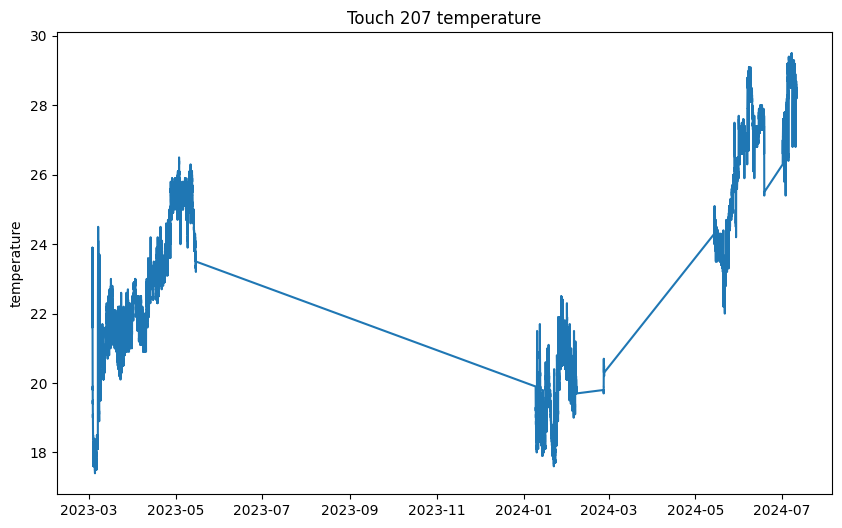

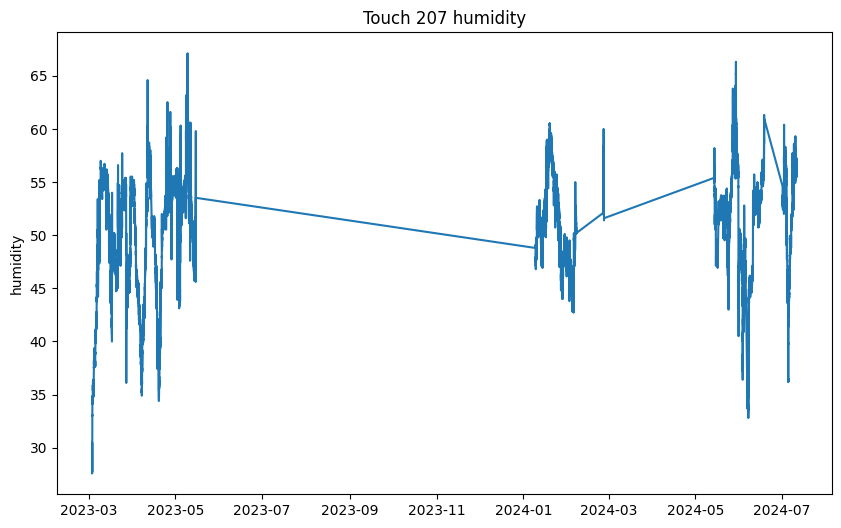

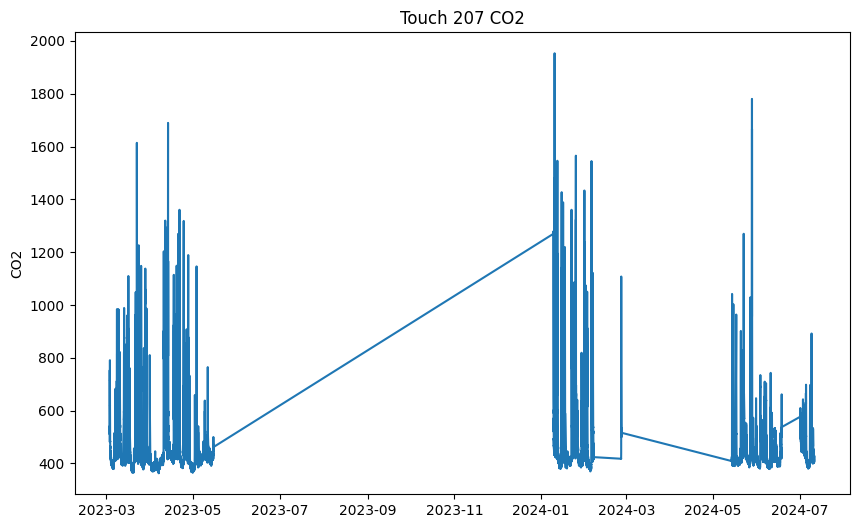

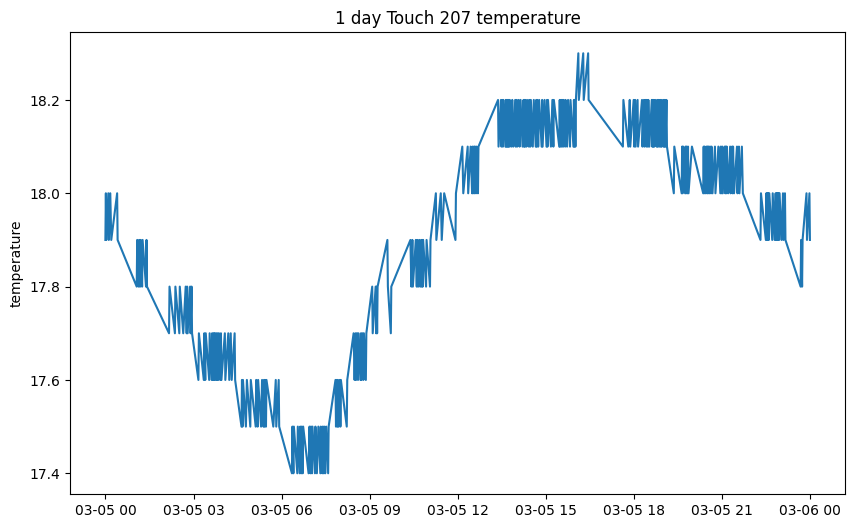

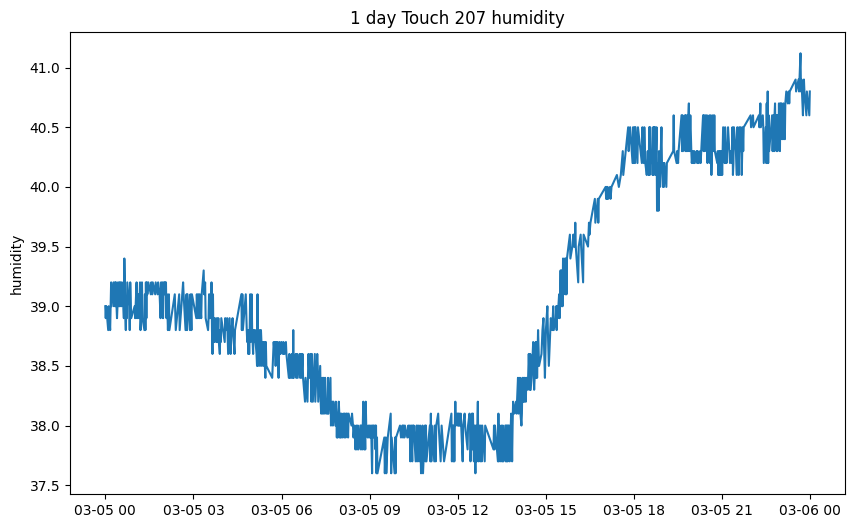

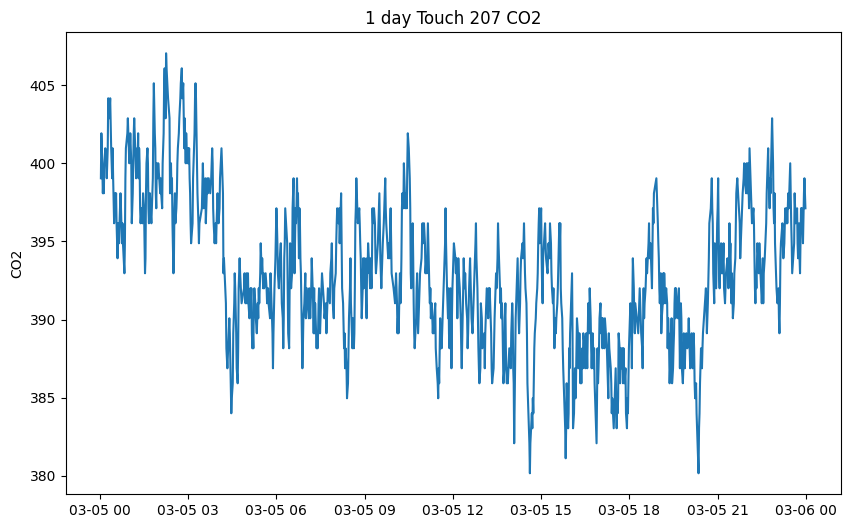

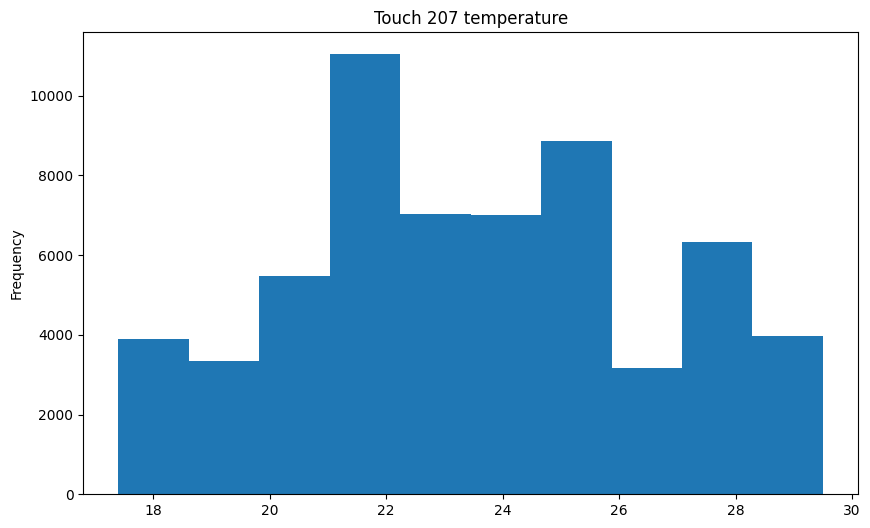

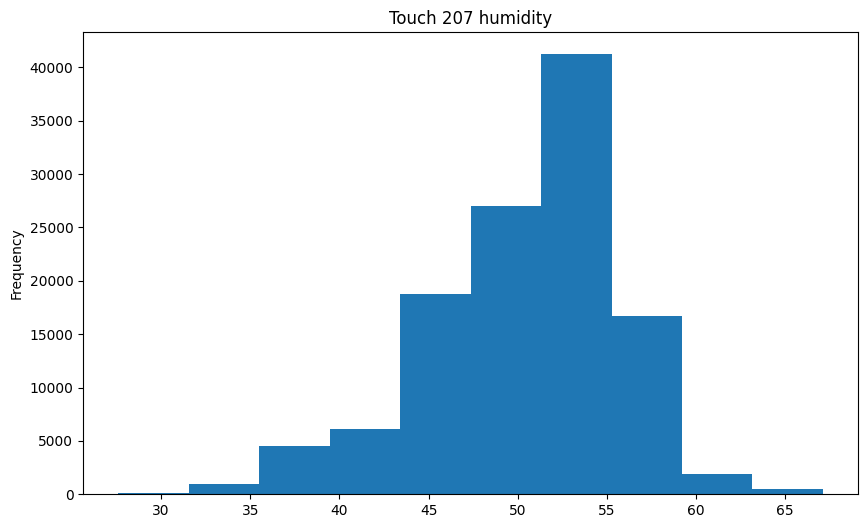

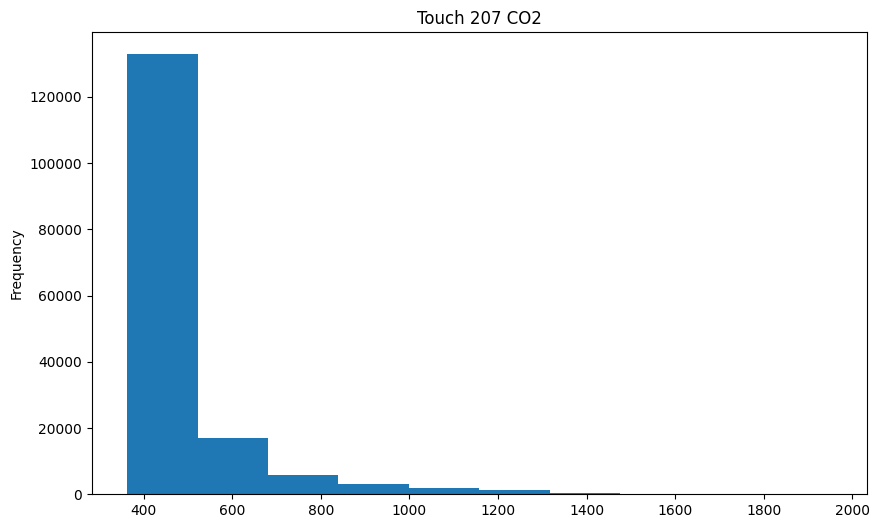

In [55]:
plot_data(df_temperature, 'temperature')
plot_data(df_humidity, 'humidity')
plot_data(df_co2, 'CO2')
plot_day_data(df_temperature, 'temperature')
plot_day_data(df_humidity, 'humidity')
plot_day_data(df_co2, 'CO2')
plot_hist(df_temperature, 'temperature')
plot_hist(df_humidity, 'humidity')
plot_hist(df_co2, 'CO2')

Debido a todos estos problemas, se ha optado por tomar únicamente el tramo entre marzo y mayo de 2023.

In [56]:
def reduce_df(df, start_date, end_date):
    return df[(df.index >= start_date) & (df.index <= end_date)]

In [57]:
reduced_df_temperature = reduce_df(df_temperature, '2023-03-01', '2023-05-15')
reduced_df_humidity = reduce_df(df_humidity, '2023-03-01', '2023-05-15')
reduced_df_co2 = reduce_df(df_co2, '2023-03-01', '2023-05-15')

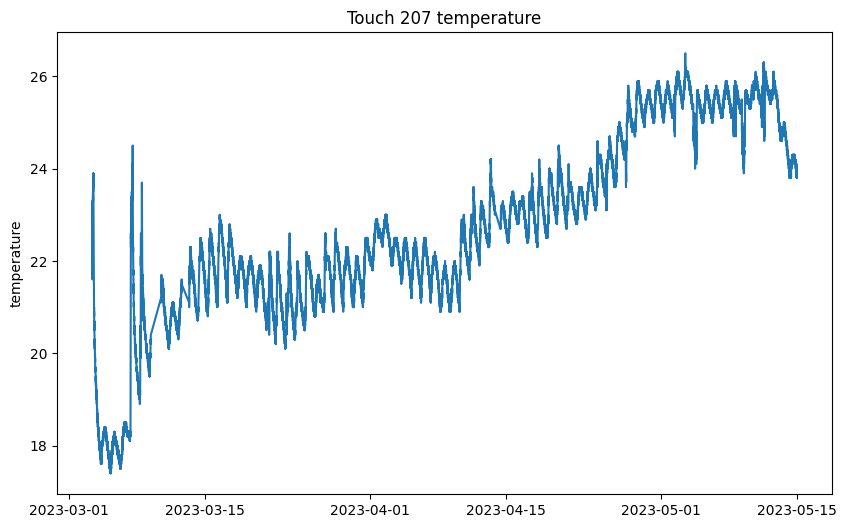

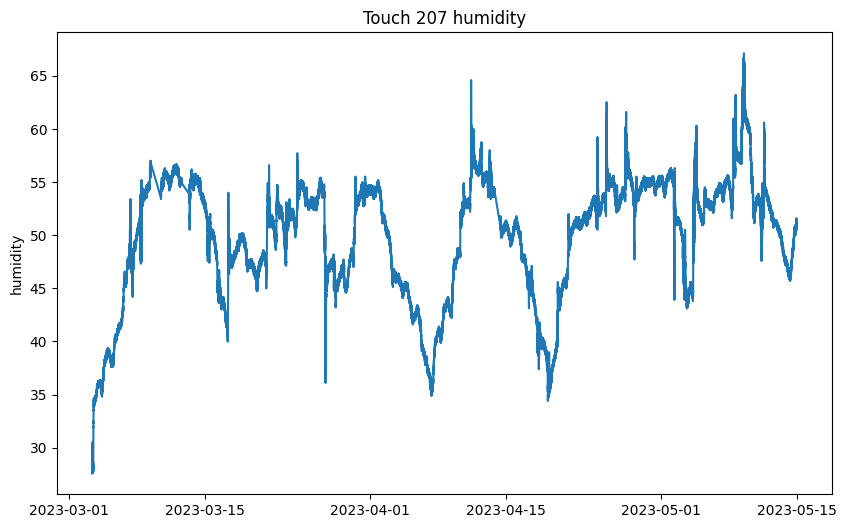

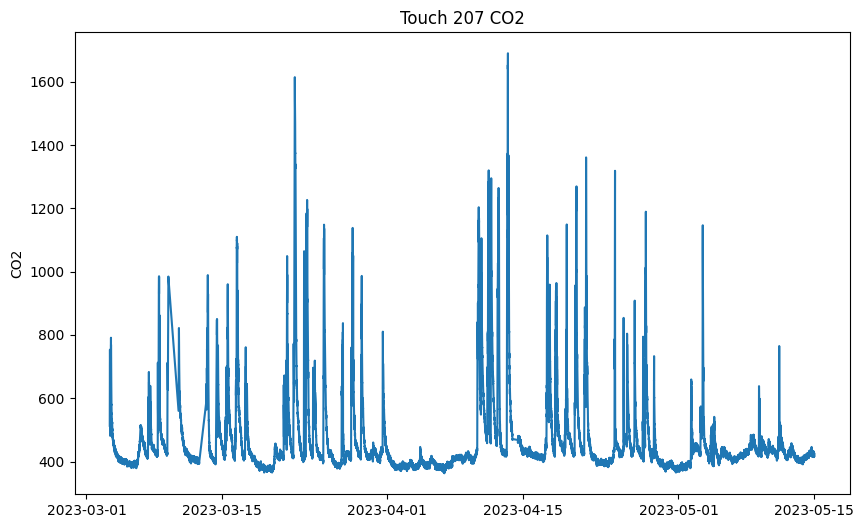

In [58]:
plot_data(reduced_df_temperature, 'temperature')
plot_data(reduced_df_humidity, 'humidity')
plot_data(reduced_df_co2, 'CO2')

Registros duplicados

In [59]:
def delete_duplicates(df, col_name):
    print(col_name + ' - Número de registros duplicados:', df.index.duplicated().sum())
    if df.index.duplicated().sum() > 0:
        df = df.groupby(df.index).mean()
        print(col_name + ' - Número de registros tras eliminar duplicados:' + str(len(df)))
    else:
        print('No hay registros duplicados')
    return df
    

In [60]:
reduced_df_temperature = delete_duplicates(reduced_df_temperature, 'temperature')
reduced_df_humidity = delete_duplicates(reduced_df_humidity, 'humidity')
reduced_df_co2 = delete_duplicates(reduced_df_co2, 'CO2')

temperature - Número de registros duplicados: 127
temperature - Número de registros tras eliminar duplicados:30039
humidity - Número de registros duplicados: 382
humidity - Número de registros tras eliminar duplicados:57889
CO2 - Número de registros duplicados: 655
CO2 - Número de registros tras eliminar duplicados:78266


In [61]:
def fill_gaps_df(df,col_name, boolean=False):
    print(col_name + " - Original data: ", len(df), "rows")
    
    # Rellenamos los valores faltantes
    df = df.resample('min').asfreq()
    if boolean:
        df[col_name] = df[col_name].interpolate(method='ffill')
    else:
        df[col_name] = df[col_name].interpolate(method='linear', limit_direction='both')
    
    print(col_name + " - Updated data: ", len(df), "rows")
    
    return df

In [62]:
reduced_df_temperature = fill_gaps_df(reduced_df_temperature, 'temperature')
reduced_df_humidity = fill_gaps_df(reduced_df_humidity, 'humidity')
reduced_df_co2 = fill_gaps_df(reduced_df_co2, 'CO2')

temperature - Original data:  30039 rows
temperature - Updated data:  104546 rows
humidity - Original data:  57889 rows
humidity - Updated data:  104549 rows
CO2 - Original data:  78266 rows
CO2 - Updated data:  104548 rows


In [63]:
reduced_df_temperature

,temperature
timestamp,
2023-03-03 09:31:00,23.10
2023-03-03 09:32:00,23.12
2023-03-03 09:33:00,23.14
2023-03-03 09:34:00,23.16
2023-03-03 09:35:00,23.18
...,...
2023-05-14 23:52:00,23.80
2023-05-14 23:53:00,23.85
2023-05-14 23:54:00,23.90


In [64]:
reduced_df_co2

,CO2
timestamp,
2023-03-03 09:31:00,512.96
2023-03-03 09:32:00,553.92
2023-03-03 09:33:00,535.04
2023-03-03 09:34:00,529.92
2023-03-03 09:35:00,529.44
...,...
2023-05-14 23:54:00,422.08
2023-05-14 23:55:00,421.12
2023-05-14 23:56:00,420.16


In [65]:
reduced_df_humidity

,humidity
timestamp,
2023-03-03 09:31:00,27.60
2023-03-03 09:32:00,28.00
2023-03-03 09:33:00,28.05
2023-03-03 09:34:00,28.10
2023-03-03 09:35:00,28.05
...,...
2023-05-14 23:55:00,51.52
2023-05-14 23:56:00,51.00
2023-05-14 23:57:00,51.12


Definimos datos de inicio y fin ignorando primer y último dia

In [66]:
reduced_df_temperature = reduced_df_temperature[(reduced_df_temperature.index >= '2023-03-06') & (reduced_df_temperature.index <= '2023-05-14')]
reduced_df_humidity = reduced_df_humidity[(reduced_df_humidity.index >= '2023-03-06') & (reduced_df_humidity.index <= '2023-05-14')]
reduced_df_co2 = reduced_df_co2[(reduced_df_co2.index >= '2023-03-06') & (reduced_df_co2.index <= '2023-05-14')]
len(reduced_df_temperature), len(reduced_df_humidity), len(reduced_df_co2)

(99361, 99361, 99361)

Normalizamos los datos

In [67]:
def normalize_df(df):
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    return df_normalized, scaler

In [68]:
reduced_df_temperature, scaler_temperature = normalize_df(reduced_df_temperature)
reduced_df_humidity, scaler_humidity = normalize_df(reduced_df_humidity)
reduced_df_co2, scaler_co2 = normalize_df(reduced_df_co2)

Por último, combinamos todos los datos en una misma tabla

In [69]:
# Merge all df into one
completed_df = pd.concat([reduced_df_temperature,  reduced_df_humidity, reduced_df_co2], axis=1)
completed_df

,temperature,humidity,CO2
timestamp,,,
2023-03-06 00:00:00,0.042857,0.192543,0.025245
2023-03-06 00:01:00,0.041270,0.195599,0.024682
2023-03-06 00:02:00,0.039683,0.197555,0.024120
2023-03-06 00:03:00,0.038095,0.199511,0.023396
2023-03-06 00:04:00,0.036508,0.201467,0.022672
...,...,...,...
2023-05-13 23:56:00,0.777778,0.382641,0.031114
2023-05-13 23:57:00,0.766667,0.388753,0.031838
2023-05-13 23:58:00,0.777778,0.382641,0.032562


## Normalización de los valores + añadir periodicidad

In [70]:
day = 60*60*24
year = 365.2425*day

completed_df['seconds'] = completed_df.index.map(pd.Timestamp.timestamp)

# A partir del seno y coseno podemos trabajar también la periodicidad de los datos. Concretamente, la de los dias y el año.

completed_df['day_sin'] = np.sin(completed_df['seconds'] * (2 * np.pi / day))
completed_df['day_cos'] = np.cos(completed_df['seconds'] * (2 * np.pi / day))
completed_df['year_sin'] = np.sin(completed_df['seconds'] * (2 * np.pi / year))
completed_df['year_cos'] = np.cos(completed_df['seconds'] * (2 * np.pi / year))

completed_df.drop(columns=['seconds'], inplace=True)

completed_df

,temperature,humidity,CO2,day_sin,day_cos,year_sin,year_cos
timestamp,,,,,,,
2023-03-06 00:00:00,0.042857,0.192543,0.025245,-1.267246e-11,1.000000,0.892796,0.450461
2023-03-06 00:01:00,0.041270,0.195599,0.024682,4.363309e-03,0.999990,0.892802,0.450450
2023-03-06 00:02:00,0.039683,0.197555,0.024120,8.726535e-03,0.999962,0.892807,0.450439
2023-03-06 00:03:00,0.038095,0.199511,0.023396,1.308960e-02,0.999914,0.892812,0.450429
2023-03-06 00:04:00,0.036508,0.201467,0.022672,1.745241e-02,0.999848,0.892818,0.450418
...,...,...,...,...,...,...,...
2023-05-13 23:56:00,0.777778,0.382641,0.031114,-1.745241e-02,0.999848,0.752028,-0.659131
2023-05-13 23:57:00,0.766667,0.388753,0.031838,-1.308960e-02,0.999914,0.752020,-0.659140
2023-05-13 23:58:00,0.777778,0.382641,0.032562,-8.726536e-03,0.999962,0.752012,-0.659149


## 5. Creación y estudio de predicciones con LSMT.

Las redes Long Shot Memory Term son las redes neuronales indicadas para llevar a cabo la predicción de valores futuros dentro de series temporales. Dentro de este cuaderno analizaremos los resultados a partir de una implementación manual y con el uso de métodos ya definidos por Tensorflow/PyTorch 

In [71]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, InputLayer, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError as mse_tf, MeanAbsoluteError as mae_tf

Antes de comenzar a definir el modelo será necesario detallar el número de datos necesarios para la entrada y la salida. En este caso, se ha optado por predecir hasta 15 minutos en el futuro a partir de los datos de los 60 minutos anteriores. Esta funcionalidad se cumple con el método split_sequences(). Las entradas (input) se localizarán en X, mientras que y será el resultado que dan. 

In [72]:
def split_sequence(df, window_size = 60, target_size = 15):
    X, y = [], []
    for i in range(len(df)-window_size-target_size):
        X.append(df.iloc[i:(i+window_size)].values)
        row = df.iloc[(i+window_size):(i+window_size+target_size)].values
        y.append(row[:, :-4].flatten())
    return np.array(X), np.array(y)

In [73]:
WINDOW_SIZE = 60
TARGET_SIZE = 15
X, y = split_sequence(completed_df, WINDOW_SIZE, TARGET_SIZE)
X.shape, y.shape

((99286, 60, 7), (99286, 45))

In [74]:
X

array([[[ 0.04285714,  0.19254279,  0.02524522, ...,  1.        ,
          0.89279631,  0.4504606 ],
        [ 0.04126984,  0.19559902,  0.02468242, ...,  0.99999048,
          0.89280169,  0.45044994],
        [ 0.03968254,  0.19755501,  0.02411963, ...,  0.99996192,
          0.89280707,  0.45043927],
        ...,
        [ 0.03939394,  0.19254279,  0.02050169, ...,  0.96923091,
          0.89310284,  0.44985256],
        [ 0.03838384,  0.18948655,  0.02122528, ...,  0.96814764,
          0.89310821,  0.44984189],
        [ 0.03737374,  0.19559902,  0.02194887, ...,  0.96704594,
          0.89311358,  0.44983122]],

       [[ 0.04126984,  0.19559902,  0.02468242, ...,  0.99999048,
          0.89280169,  0.45044994],
        [ 0.03968254,  0.19755501,  0.02411963, ...,  0.99996192,
          0.89280707,  0.45043927],
        [ 0.03809524,  0.199511  ,  0.02339604, ...,  0.99991433,
          0.89281245,  0.45042861],
        ...,
        [ 0.03838384,  0.18948655,  0.02122528, ...,  

In [75]:
y

array([[0.03636364, 0.18948655, 0.02411963, ..., 0.03333333, 0.20782396,
        0.02580801],
       [0.03535354, 0.19559902, 0.02508442, ..., 0.04444444, 0.19254279,
        0.0261698 ],
       [0.03434343, 0.200489  , 0.02460203, ..., 0.0437037 , 0.19559902,
        0.0265316 ],
       ...,
       [0.77222222, 0.39486553, 0.03666184, ..., 0.76666667, 0.38875306,
        0.03183792],
       [0.77777778, 0.39792176, 0.03617945, ..., 0.77777778, 0.38264059,
        0.03256151],
       [0.76666667, 0.400978  , 0.03714424, ..., 0.76666667, 0.38875306,
        0.03328509]])

In [76]:
lsmt_separation_rows = int(len(X)*0.8)
X_train, X_test = X[:lsmt_separation_rows], X[lsmt_separation_rows:]
y_train, y_test = y[:lsmt_separation_rows], y[lsmt_separation_rows:]

len(X_train), len(X_test), len(y_train), len(y_test)

(79428, 19858, 79428, 19858)

In [77]:
HandMadeLSTM = Sequential()
HandMadeLSTM.add(InputLayer((WINDOW_SIZE, len(completed_df.columns))))
HandMadeLSTM.add(LSTM(64, activation='relu'))
HandMadeLSTM.add(Dense(TARGET_SIZE*(len(completed_df.columns)-4)))

HandMadeLSTM.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 45)             │         2,925 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,357 (83.43 KB)

 Trainable params: 21,357 (83.43 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
modelPath = '../LSMTTensorflow/bestModelTouch207.keras'
checkpoints = ModelCheckpoint(modelPath, save_best_only=True)
HandMadeLSTM.compile(optimizer=Adam(learning_rate=0.001), loss=mse_tf(), metrics=[mae_tf(), RootMeanSquaredError()])

In [79]:
HandMadeLSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[checkpoints])

Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.0118 - mean_absolute_error: 0.0523 - root_mean_squared_error: 0.0946 - val_loss: 5.1188e-04 - val_mean_absolute_error: 0.0137 - val_root_mean_squared_error: 0.0226
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 2.6011e-04 - mean_absolute_error: 0.0089 - root_mean_squared_error: 0.0161 - val_loss: 4.7369e-04 - val_mean_absolute_error: 0.0137 - val_root_mean_squared_error: 0.0218
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 2.2845e-04 - mean_absolute_error: 0.0083 - root_mean_squared_error: 0.0151 - val_loss: 4.5671e-04 - val_mean_absolute_error: 0.0142 - val_root_mean_squared_error: 0.0214
Epoch 4/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 2.1301e-04 - mean_absolute_error: 0.0078 - root_mean_squared_error: 0.0146 - val_loss: 3.4103e-04 - val_mean_absolute_error: 0.0095 - val_root_mean_squared_error: 0.0185
Epoch 5/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 2.08

In [80]:
HandMadeLSTM = load_model(modelPath)

In [81]:
test_predictions = HandMadeLSTM.predict(X_test)
test_predictions.shape

621/621 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


(19858, 45)

In [82]:
y_test

array([[0.83333333, 0.64547677, 0.0197781 , ..., 0.84      , 0.63814181,
        0.0265316 ],
       [0.84444444, 0.63325183, 0.02267246, ..., 0.84111111, 0.63691932,
        0.02870236],
       [0.83888889, 0.6393643 , 0.02424023, ..., 0.84222222, 0.63569682,
        0.02942595],
       ...,
       [0.77222222, 0.39486553, 0.03666184, ..., 0.76666667, 0.38875306,
        0.03183792],
       [0.77777778, 0.39792176, 0.03617945, ..., 0.77777778, 0.38264059,
        0.03256151],
       [0.76666667, 0.400978  , 0.03714424, ..., 0.76666667, 0.38875306,
        0.03328509]])

In [83]:
# Destransformamos los datos
def inverse_transform_dataset(predictions, test):
    test_predictions_temperature = scaler_temperature.inverse_transform(predictions[:, ::3]).flatten()
    test_predictions_humidity = scaler_humidity.inverse_transform(predictions[:, 1::3]).flatten()
    test_predictions_co2 = scaler_co2.inverse_transform(predictions[:, 2::3]).flatten()

    y_test_temperature = scaler_temperature.inverse_transform(test[:, ::3]).flatten()
    y_test_humidity = scaler_humidity.inverse_transform(test[:, 1::3]).flatten()
    y_test_co2 = scaler_co2.inverse_transform(test[:, 2::3]).flatten()
    
    return test_predictions_temperature, test_predictions_humidity, test_predictions_co2, y_test_temperature, y_test_humidity, y_test_co2

test_predictions_temperature, test_predictions_humidity, test_predictions_co2, y_test_temperature, y_test_humidity, y_test_co2 = inverse_transform_dataset(test_predictions, y_test)

In [84]:
def plot_predictions(y_test, test_predictions, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(y_test, label='True')
    plt.plot(test_predictions, label='Predicted')
    plt.title('Touch 207 ' + col_name)
    plt.ylabel(col_name)
    plt.legend()
    plt.show()
    
def plot_predictions_day(y_test, test_predictions, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(y_test[:1440], label='True')
    plt.plot(test_predictions[:1440], label='Predicted')
    plt.title('Touch 207 ' + col_name + ' - 1 day')
    plt.ylabel(col_name)
    plt.legend()
    plt.show()

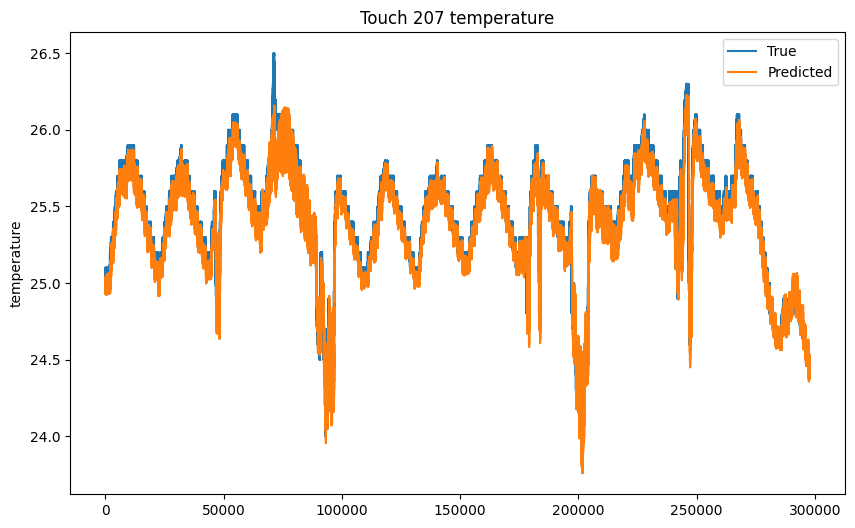

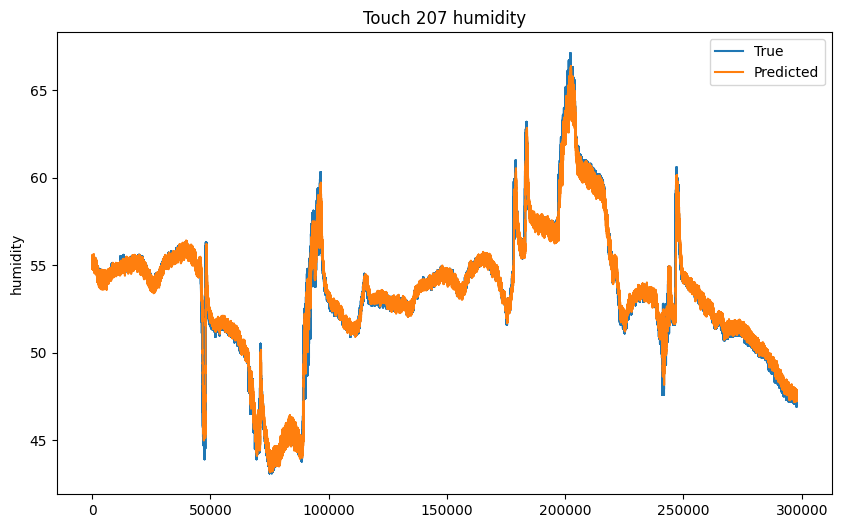

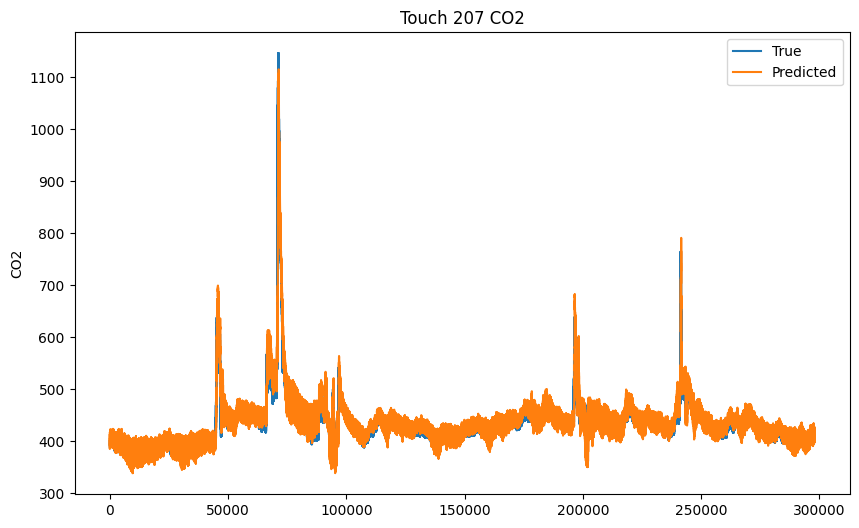

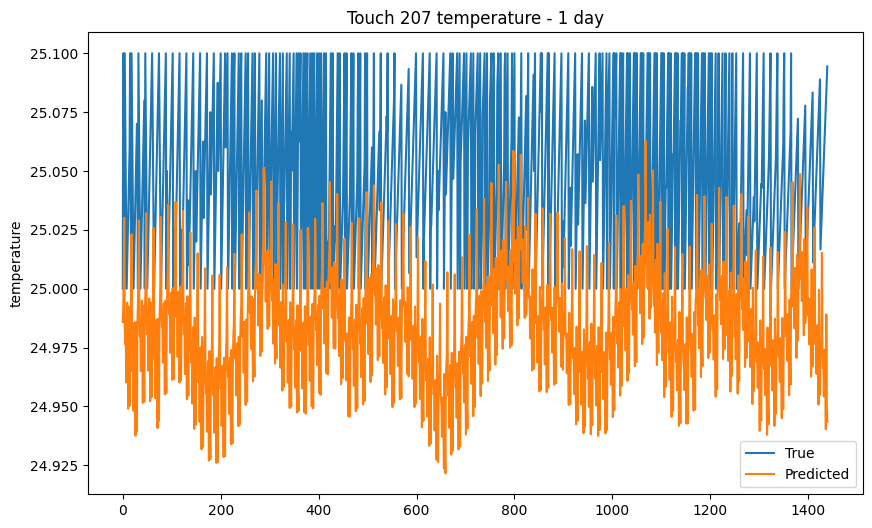

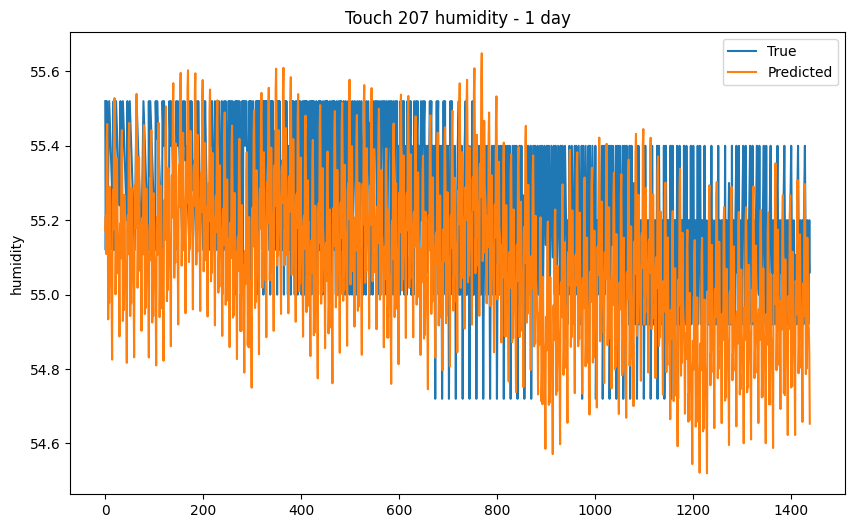

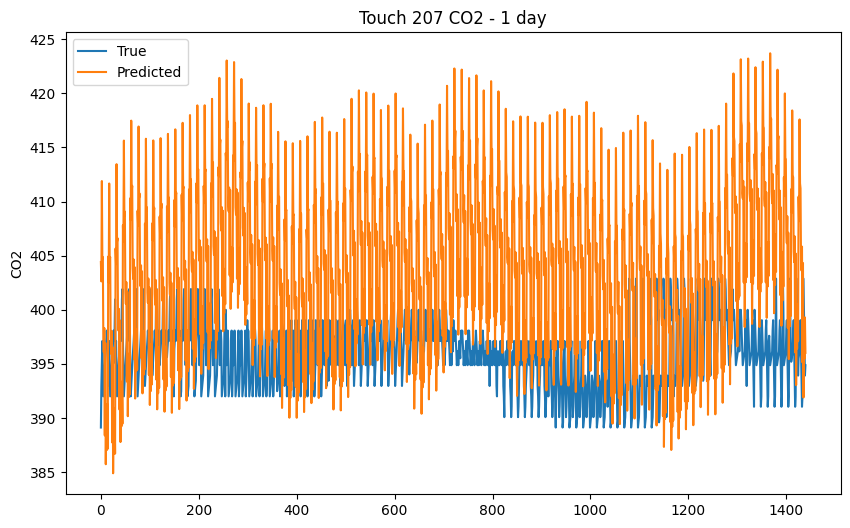

In [85]:
plot_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
plot_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
plot_predictions(y_test_co2, test_predictions_co2, 'CO2')

plot_predictions_day(y_test_temperature, test_predictions_temperature, 'temperature')
plot_predictions_day(y_test_humidity, test_predictions_humidity, 'humidity')
plot_predictions_day(y_test_co2, test_predictions_co2, 'CO2')

In [86]:
# Evaluate the predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_predictions(y_test, test_predictions, name):
    print(name +' - MSE:', mean_squared_error(y_test, test_predictions))
    print(name +' - MAE:', mean_absolute_error(y_test, test_predictions))
    print(name +' - RMSE:', np.sqrt(mean_squared_error(y_test, test_predictions)))
    
evaluate_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
evaluate_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
evaluate_predictions(y_test_co2, test_predictions_co2, 'CO2')

temperature - MSE: 0.012362280177706764
temperature - MAE: 0.08313474043642469
temperature - RMSE: 0.11118579125817635
humidity - MSE: 0.28835564241516465
humidity - MAE: 0.32657168442685136
humidity - RMSE: 0.5369875626261419
CO2 - MSE: 379.08190916730337
CO2 - MAE: 13.557298309350829
CO2 - RMSE: 19.470025915938155


### Multistep / Predecir valores dentro de 60 minutos

Evaluamos para 60 minutos, 360 minutos y 720 minutos

In [87]:
horizons = [60, 360, 720]

Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0201 - mean_absolute_error: 0.0737 - root_mean_squared_error: 0.1259 - val_loss: 0.0016 - val_mean_absolute_error: 0.0264 - val_root_mean_squared_error: 0.0404
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 926us/step - loss: 8.0967e-04 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0284 - val_loss: 0.0014 - val_mean_absolute_error: 0.0222 - val_root_mean_squared_error: 0.0373
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 877us/step - loss: 7.3183e-04 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0270 - val_loss: 0.0014 - val_mean_absolute_error: 0.0237 - val_root_mean_squared_error: 0.0376
Epoch 4/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 893us/step - loss: 7.3044e-04 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0270 - val_loss: 0.0013 - val_mean_absolute_error: 0.0208 - val_root_mean_squared_error: 0.0359
Epoch 5/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 892us/step - loss: 7.4010e-04 - mean_abso

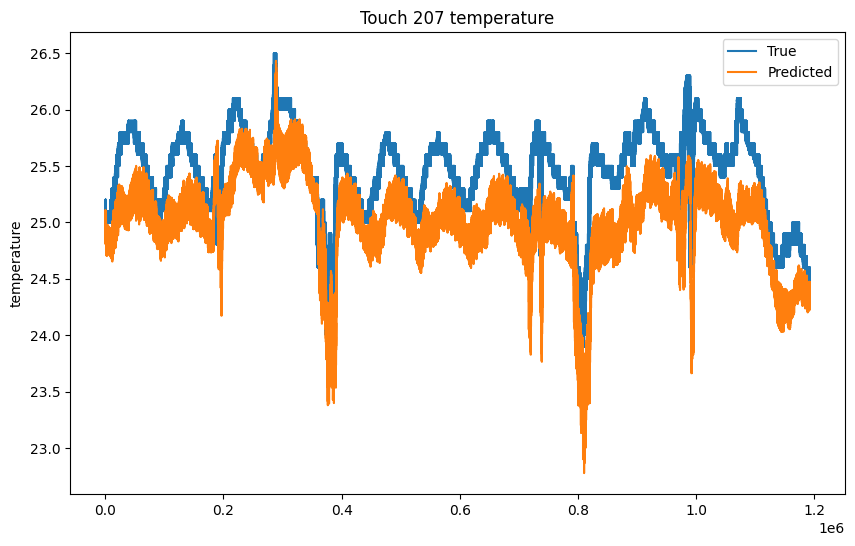

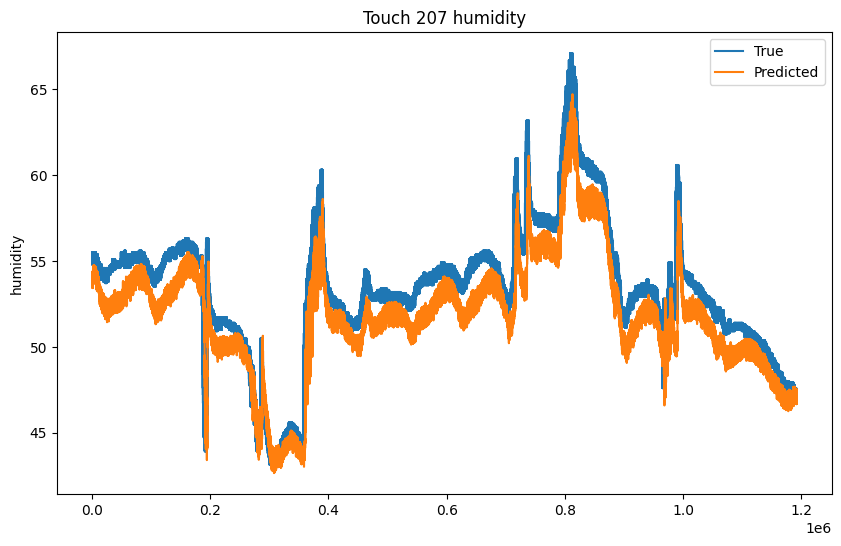

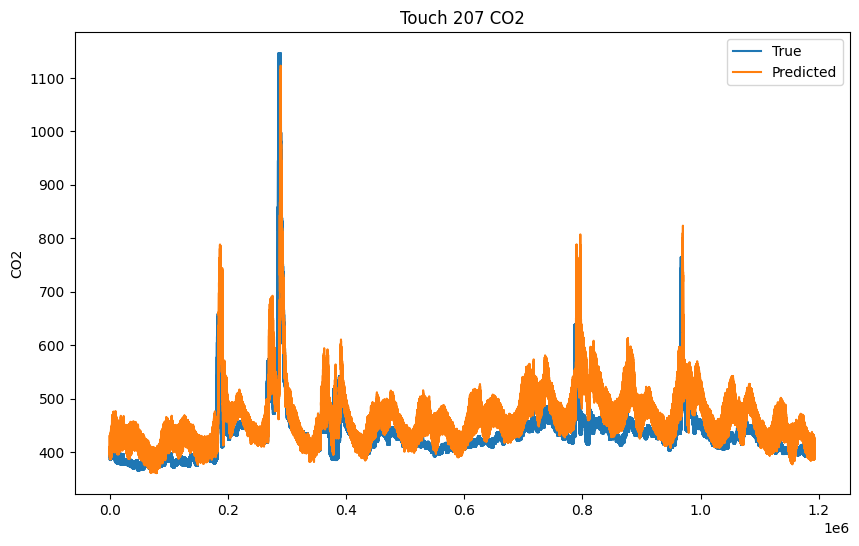

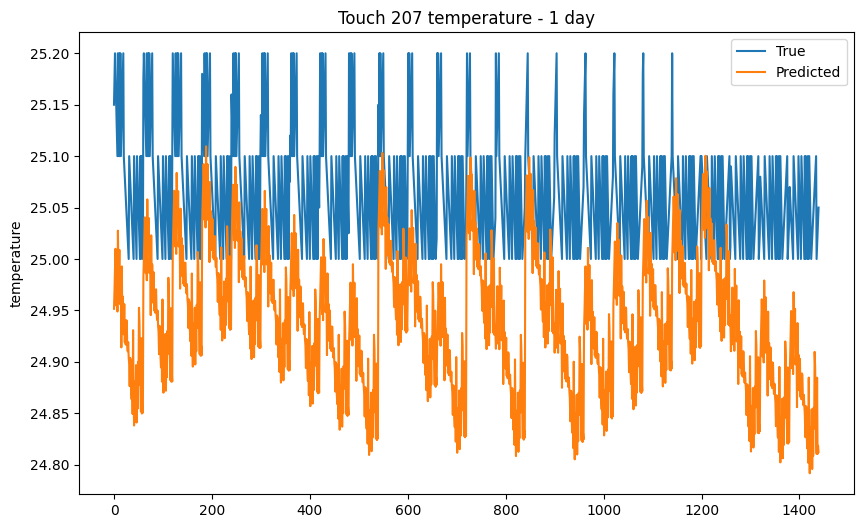

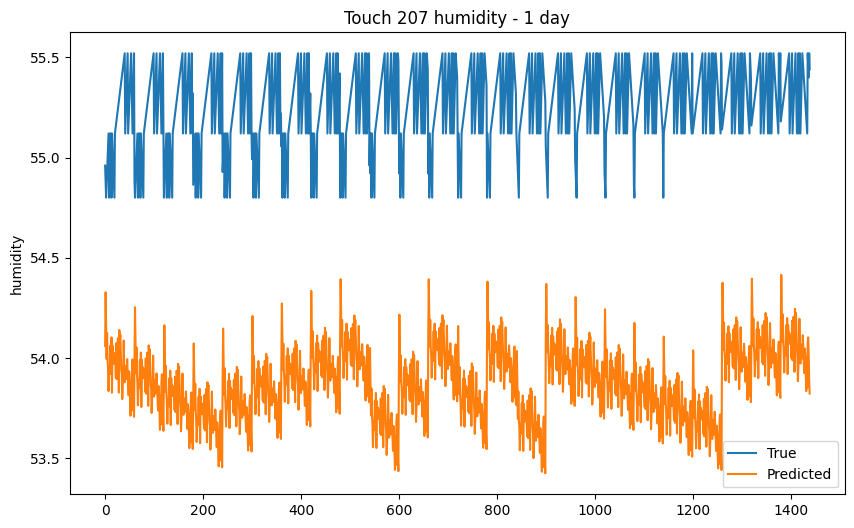

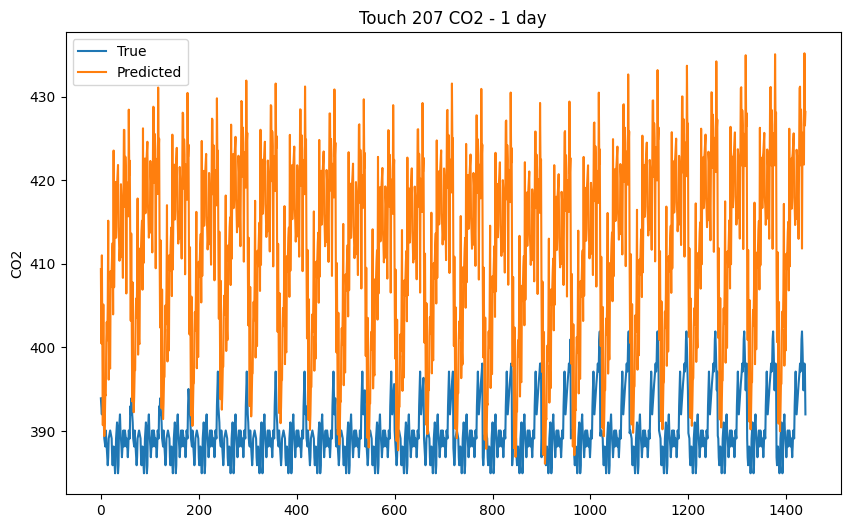

temperature - MSE: 0.2553391687539312
temperature - MAE: 0.4431960515830409
temperature - RMSE: 0.5053109624319774
humidity - MSE: 3.3871875235964497
humidity - MAE: 1.588223204789692
humidity - RMSE: 1.8404313417230347
CO2 - MSE: 2849.572034771798
CO2 - MAE: 40.91813538173313
CO2 - RMSE: 53.381382848066025
Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0218 - mean_absolute_error: 0.0856 - root_mean_squared_error: 0.1348 - val_loss: 0.0031 - val_mean_absolute_error: 0.0315 - val_root_mean_squared_error: 0.0556
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0033 - mean_absolute_error: 0.0297 - root_mean_squared_error: 0.0574 - val_loss: 0.0032 - val_mean_absolute_error: 0.0328 - val_root_mean_squared_error: 0.0565
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0031 - mean_absolute_error: 0.0287 - root_mean_squared_error: 0.0557 - val_loss: 0.0032 - val_mean_absolute_error: 0.0333 - val_root_mean_squared_error: 0.0570
Epoch 4/20
1986/198

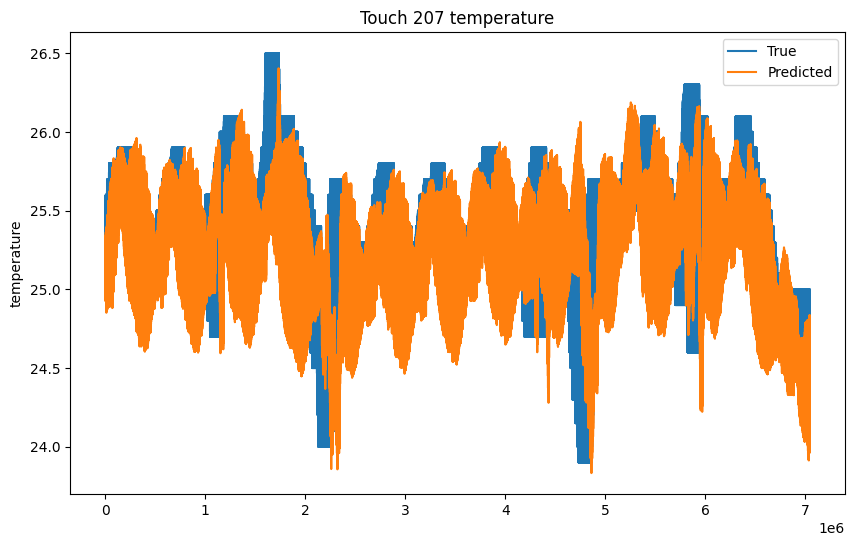

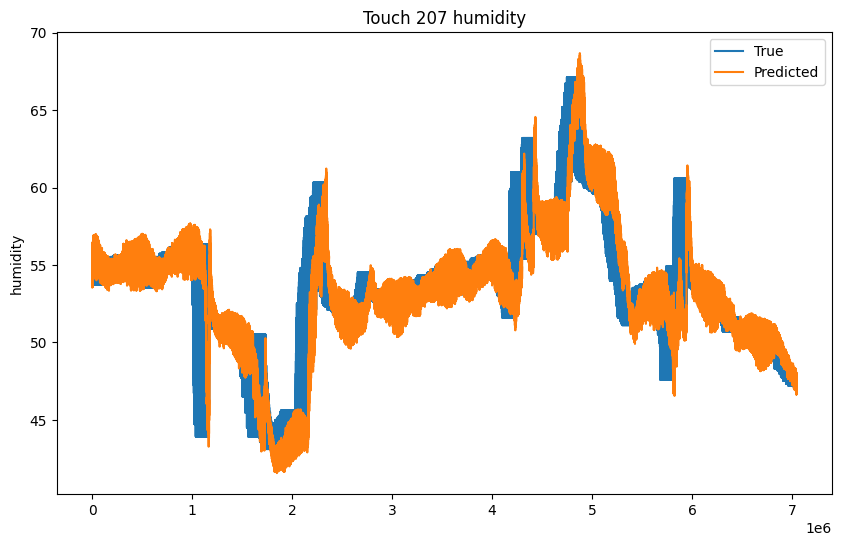

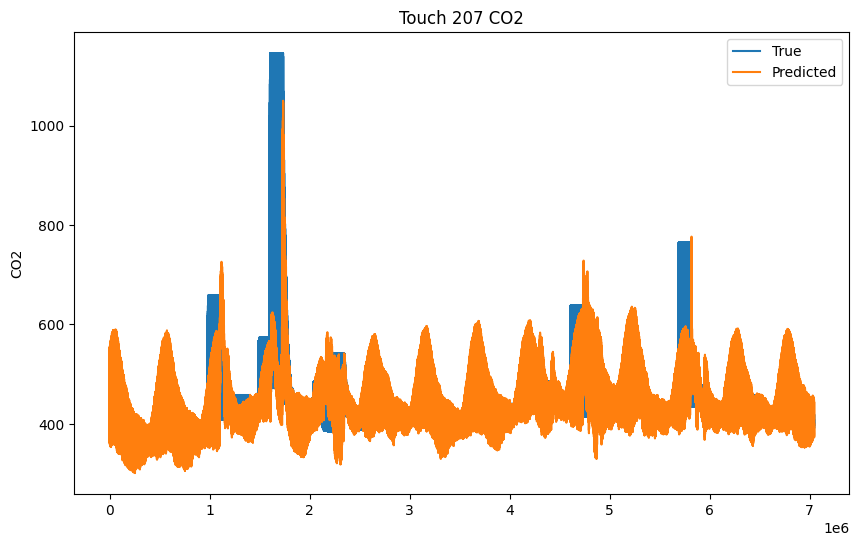

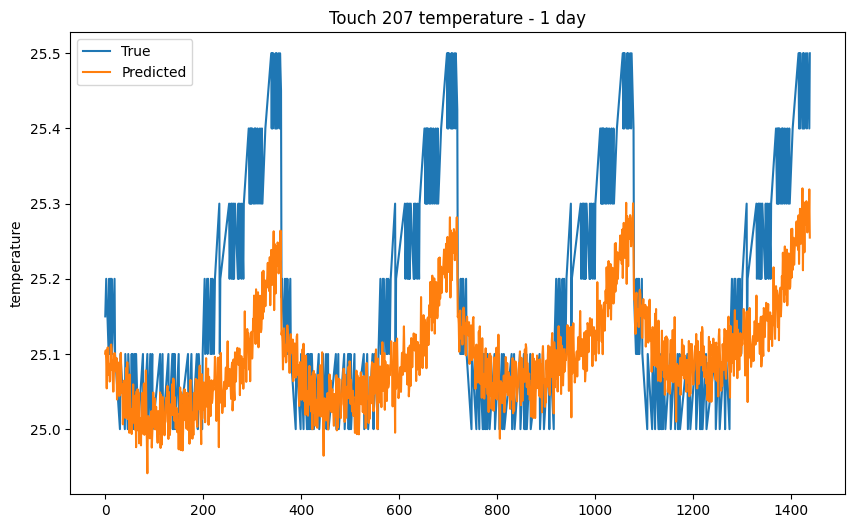

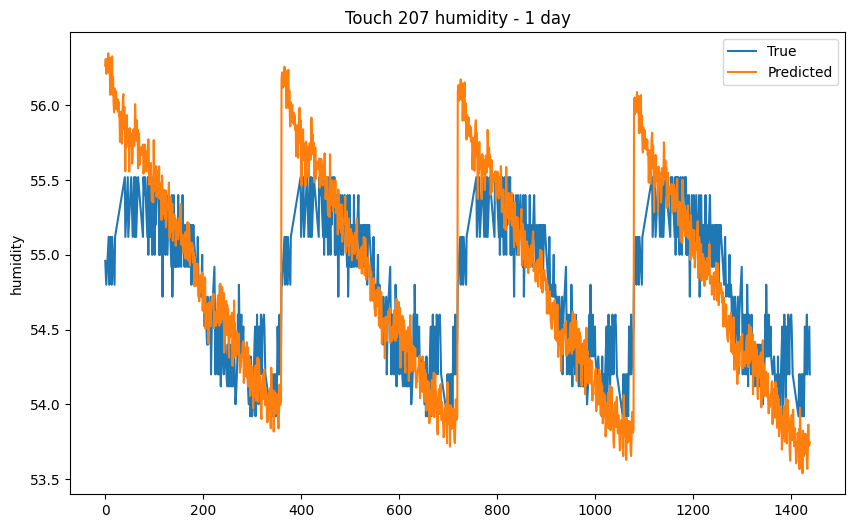

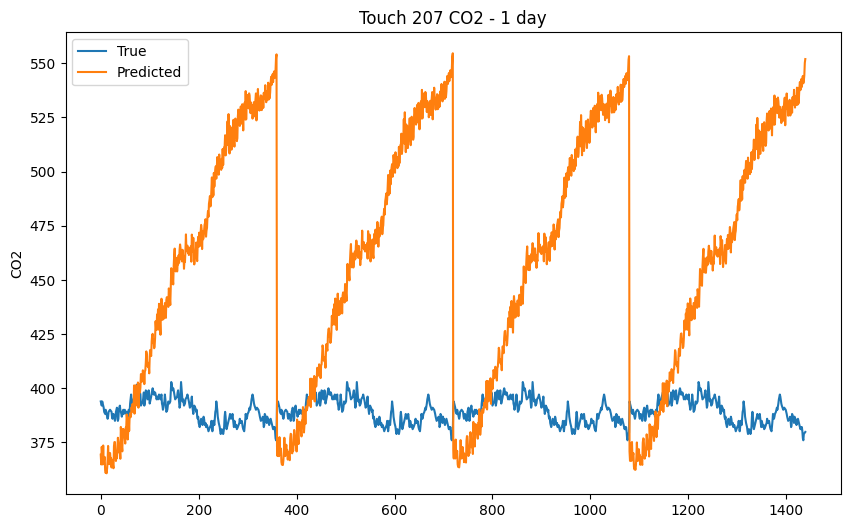

temperature - MSE: 0.15304562412484382
temperature - MAE: 0.29122773575474376
temperature - RMSE: 0.3912104601424198
humidity - MSE: 3.8807330180946553
humidity - MAE: 1.1666012233508256
humidity - RMSE: 1.9699576183498606
CO2 - MSE: 4384.343796119384
CO2 - MAE: 43.70174354446271
CO2 - RMSE: 66.21437756348227
Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0226 - mean_absolute_error: 0.0906 - root_mean_squared_error: 0.1388 - val_loss: 0.0049 - val_mean_absolute_error: 0.0463 - val_root_mean_squared_error: 0.0702
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0044 - mean_absolute_error: 0.0380 - root_mean_squared_error: 0.0666 - val_loss: 0.0048 - val_mean_absolute_error: 0.0451 - val_root_mean_squared_error: 0.0691
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0042 - mean_absolute_error: 0.0369 - root_mean_squared_error: 0.0650 - val_loss: 0.0051 - val_mean_absolute_error: 0.0471 - val_root_mean_squared_error: 0.0713
Epoch 4/20
1986/1

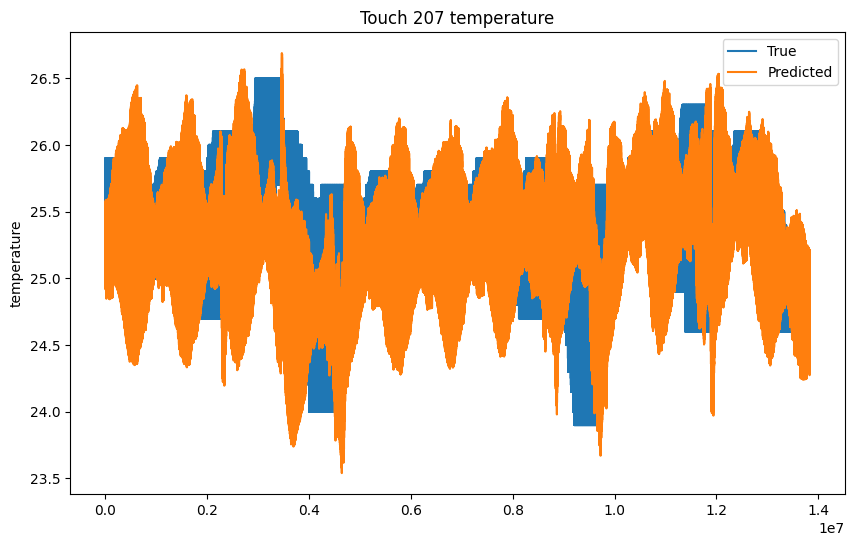

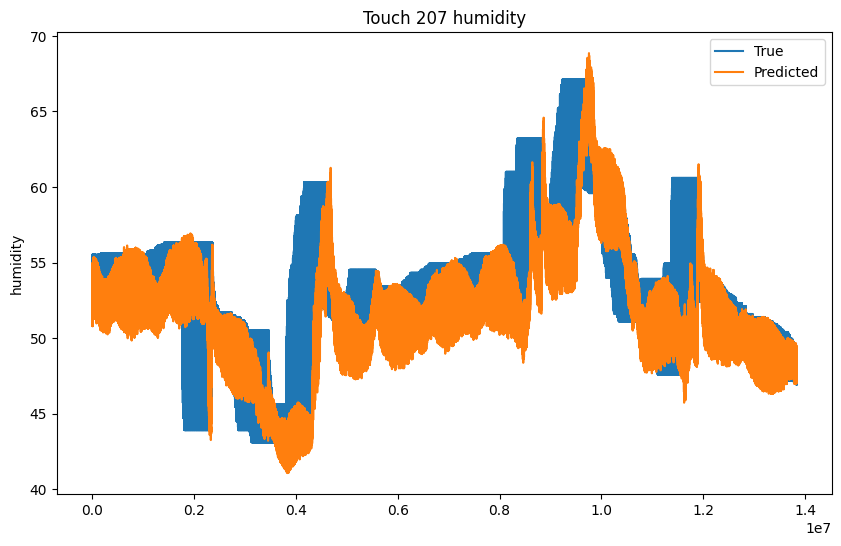

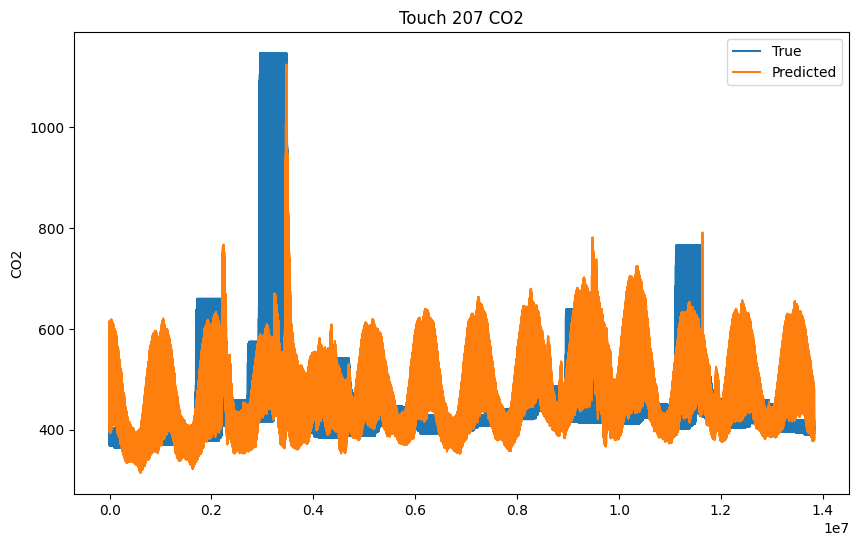

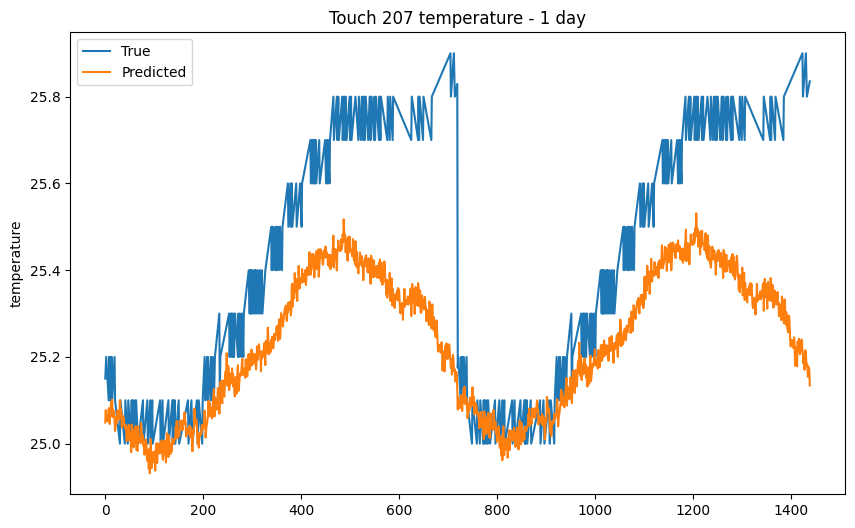

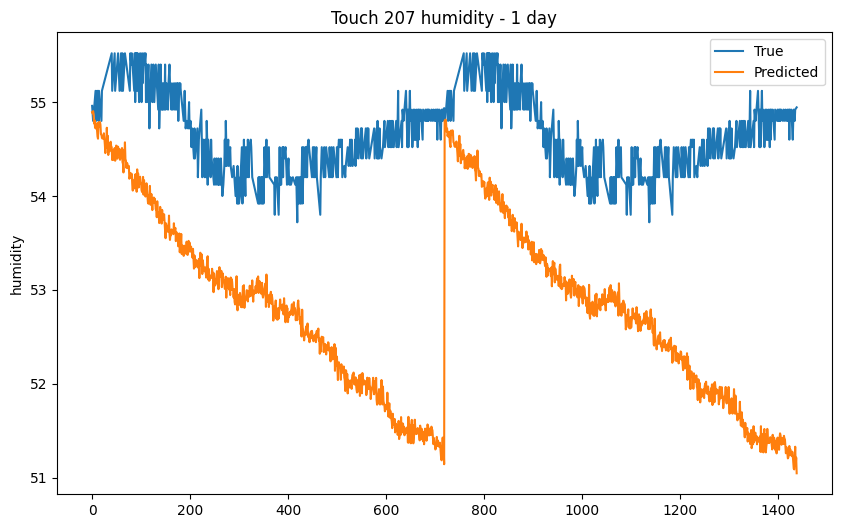

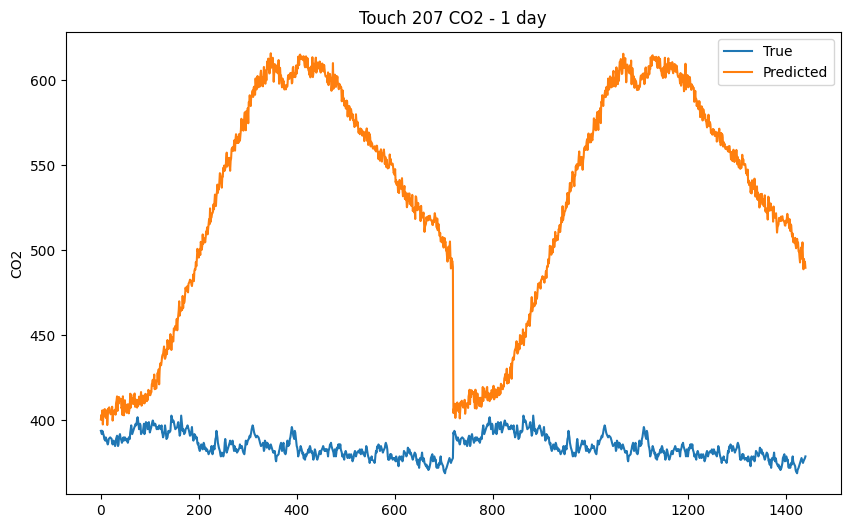

temperature - MSE: 0.22706613297835865
temperature - MAE: 0.3618735587491719
temperature - RMSE: 0.47651456743562276
humidity - MSE: 9.643390560385678
humidity - MAE: 2.1069989179916258
humidity - RMSE: 3.1053809042347247
CO2 - MSE: 7611.380823509371
CO2 - MAE: 61.35843285010986
CO2 - RMSE: 87.24322795214177


In [88]:
for horizon in horizons:
    X, y = split_sequence(completed_df, 1, horizon)
    X_train, X_test = X[:lsmt_separation_rows], X[lsmt_separation_rows:]
    y_train, y_test = y[:lsmt_separation_rows], y[lsmt_separation_rows:]

    HandMadeLSTM = Sequential()
    HandMadeLSTM.add(InputLayer((1, len(completed_df.columns))))
    HandMadeLSTM.add(LSTM(64, activation='relu'))
    HandMadeLSTM.add(Dense(horizon*(len(completed_df.columns)-4)))

    modelPath = f'../LSMTTensorflow/bestModel_touch_207_{horizon}.keras'
    checkpoints = ModelCheckpoint(modelPath, save_best_only=True)
    HandMadeLSTM.compile(optimizer=Adam(learning_rate=0.001), loss=mse_tf(), metrics=[mae_tf(), RootMeanSquaredError()])

    HandMadeLSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[checkpoints])

    HandMadeLSTM = load_model(modelPath)

    test_predictions_temperature, test_predictions_humidity, test_predictions_co2, y_test_temperature, y_test_humidity, y_test_co2 = inverse_transform_dataset(HandMadeLSTM.predict(X_test), y_test)
    
    plot_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
    plot_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
    plot_predictions(y_test_co2, test_predictions_co2, 'CO2')

    plot_predictions_day(y_test_temperature, test_predictions_temperature, 'temperature')
    plot_predictions_day(y_test_humidity, test_predictions_humidity, 'humidity')
    plot_predictions_day(y_test_co2, test_predictions_co2, 'CO2')
    
    evaluate_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
    evaluate_predictions(y_test_humidity, test_predictions_humidity, 'humidity')
    evaluate_predictions(y_test_co2, test_predictions_co2, 'CO2')
    
    

In [89]:
# Guardamos los datos necesarios para transformar los datos de normalización a los datos originales
dump(scaler_temperature, open('scalers/touch/scaler_temperature_touch_207.pkl', 'wb'))
dump(scaler_humidity, open('scalers/touch/scaler_humidity_touch_207.pkl', 'wb'))
dump(scaler_co2, open('scalers/touch/scaler_co2_touch_207.pkl', 'wb'))


In [90]:
scaler_temperature.data_max_, scaler_humidity.data_max_, scaler_co2.data_max_, scaler_temperature.data_min_, scaler_humidity.data_min_, scaler_co2.data_min_

(array([26.5]),
 array([67.12]),
 array([1689.6]),
 array([17.5]),
 array([34.4]),
 array([362.88]))